In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
import itertools
import numpy as np
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LinearSegmentedColormap, PowerNorm
import matplotlib.lines as mlines
import matplotlib.markers as markers
from itertools import count
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Dataset de latitudes y longitudes
## Fuente: https://developers.google.com/public-data/docs/canonical/countries_csv

In [2]:
geo_data = pd.read_csv('lat_long_countries.csv', sep=';',header=0)
geo_data['LATITUDE'] = geo_data['LATITUDE'].replace(',', '.', regex=True).apply(pd.to_numeric)
geo_data['LONGITUDE'] = geo_data['LONGITUDE'].replace(',', '.', regex=True).apply(pd.to_numeric)
geo_data

CODE   LATITUDE   LONGITUDE                           COUNTRY
0     AD  42.546245    1.601554                           Andorra
1     AE  23.424076   53.847818              United Arab Emirates
2     AF  33.939110   67.709953                       Afghanistan
3     AG  17.060816  -61.796428               Antigua and Barbuda
4     AI  18.220554  -63.068615                          Anguilla
5     AL  41.153332   20.168331                           Albania
6     AM  40.069099   45.038189                           Armenia
7     AN  12.226079  -69.060087              Netherlands Antilles
8     AO -11.202692   17.873887                            Angola
9     AQ -75.250973   -0.071389                        Antarctica
10    AR -38.416097  -63.616672                         Argentina
11    AS -14.270972 -170.132217                    American Samoa
12    AT  47.516231   14.550072                           Austria
13    AU -25.274398  133.775136                         Australia
14    AW  12.521110  -69.968338                             Aruba
15    AZ  40.143105   47.576927                        Azerbaijan
16    BA  43.915886   17.679076            Bosnia and Herzegovina
17    BB  13.193887  -59.543198                          Barbados
18    BD  23.684994   90.356331                        Bangladesh
19    BE  50.503887    4.469936                           Belgium
20    BF  12.238333   -1.561593                      Burkina Faso
21    BG  42.733883   25.485830                          Bulgaria
22    BH  25.930414   50.637772                           Bahrain
23    BI  -3.373056   29.918886                           Burundi
24    BJ   9.307690    2.315834                             Benin
25    BM  32.321384  -64.757370                           Bermuda
26    BN   4.535277  114.727669                            Brunei
27    BO -16.290154  -63.588653                           Bolivia
28    BR -14.235004  -51.925280                            Brazil
29    BS  25.034280  -77.396280                           Bahamas
..   ...        ...         ...                               ...
215   TL  -8.874217  125.727539                       Timor-Leste
216   TM  38.969719   59.556278                      Turkmenistan
217   TN  33.886917    9.537499                           Tunisia
218   TO -21.178986 -175.198242                             Tonga
219   TR  38.963745   35.243322                            Turkey
220   TT  10.691803  -61.222503               Trinidad and Tobago
221   TV  -7.109535  177.649330                            Tuvalu
222   TW  23.697810  120.960515                            Taiwan
223   TZ  -6.369028   34.888822                          Tanzania
224   UA  48.379433   31.165580                           Ukraine
225   UG   1.373333   32.290275                            Uganda
226   UM        NaN         NaN       U.S. Minor Outlying Islands
227   US  37.090240  -95.712891                     United States
228   UY -32.522779  -55.765835                           Uruguay
229   UZ  41.377491   64.585262                        Uzbekistan
230   VA  41.902916   12.453389                      Vatican City
231   VC  12.984305  -61.287228  Saint Vincent and the Grenadines
232   VE   6.423750  -66.589730                         Venezuela
233   VG  18.420695  -64.639968            British Virgin Islands
234   VI  18.335765  -64.896335               U.S. Virgin Islands
235   VN  14.058324  108.277199                           Vietnam
236   VU -15.376706  166.959158                           Vanuatu
237   WF -13.768752 -177.156097                 Wallis and Futuna
238   WS -13.759029 -172.104629                             Samoa
239   XK  42.602636   20.902977                            Kosovo
240   YE  15.552727   48.516388                             Yemen
241   YT -12.827500   45.166244                           Mayotte
242   ZA -30.559482   22.937506                      South Africa
243   ZM -13.133897   27.849332             

# Dataset de RASFF

In [ ]:
data = pd.read_csv('C:/Users/Ceiec04/Desktop/Prediccion_Alertas_Alimentarias/Datasets/full_RASFF_DATA_16092019.csv', sep=';', 
                   header=0, index_col = 0)
data['DATE_CASE'] =pd.to_datetime(data.DATE_CASE, yearfirst=True, format = '%d/%m/%Y')
data = data.replace('Falkland Islands','Falkland Islands [Islas Malvinas]',regex=True)
data = data.replace('Myanmar','Myanmar [Burma]',regex=True)
data = data.replace("Côte d'Ivoire","C?te d'Ivoire",regex=True)
data = data.replace("Faeroe Islands","Faroe Islands",regex=True)
data = data.replace("Democratic Republic of the Congo","xxxx",regex=True)
data = data.replace("Congo","Congo [Republic]",regex=True)
data = data.replace("xxxx","Congo [DRC]",regex=True)
data = data.replace("Republic of North Macedonia","Macedonia [FYROM]",regex=True)
data = data.replace("Curaçao","Netherlands Antilles",regex=True)
data = data.replace("West Bank and Gaza Strip","Gaza Strip",regex=True)
data = data.replace("Saint Barthélemy","Guadeloupe",regex=True)
data = data.replace("Macao","Macau",regex=True)
data = data.replace("Sint Maarten","Netherlands Antilles",regex=True)
data = data.replace("Saint Martin","Netherlands Antilles",regex=True)
data = data.replace("São Tomé and Príncipe","Gabon",regex=True)
data = data.replace("Åland Islands","Finland",regex=True)
data = data.replace("East Timor","Timor-Leste",regex=True)
data = data.replace("Réunion","Mauritius",regex=True)
data = data.replace("US Virgin Islands","U.S. Virgin Islands",regex=True)
data = data.replace("Serbia and Montenegro","Serbia",regex=True)

# Preprocesamiento

In [4]:
all_routes = []

for index, row in data.iterrows():
    origin=row['COUNT_ORIGEN'].split(",")   
    destiny=row['COUNT_DESTIN'].split(",") 
    concern=row['COUNT_CONCERN'].split(",")
    

    for i in origin:
        
        if i!=" " and i!= 'INFOSAN' and i!='Commission Services'and i!='unknown origin'and i!='European Food Safety Authority': 
            for j in destiny:
                if j!=" " and i!=j and j!= 'INFOSAN' and j!='Commission Services'and j!='unknown origin'and j!='European Food Safety Authority': 
                    route = []
                    route.append(i)
                    route.append(j)
                    all_routes.append(route)
                    
                    for k in concern:
                        if k!=" " and k!= 'INFOSAN' and k!='Commission Services'and k!='unknown origin'and k!='European Food Safety Authority':
                            route = []
                            route.append(i)
                            route.append(k)
                            all_routes.append(route)   
                else:
                    for k in concern:
                        if k!=" " and k!= 'INFOSAN' and k!='Commission Services'and k!='unknown origin'and k!='European Food Safety Authority':
                            route = []
                            route.append(i)
                            route.append(k)
                            all_routes.append(route)              

In [ ]:
routes = pd.DataFrame(all_routes)
routes.columns = 'Origen', 'Destino'

origen_size = routes['Origen'].value_counts()
origen_size = pd.DataFrame(origen_size).reset_index()
origen_size.columns = ('COUNTRY', 'Origen_size')

destino_size = routes['Destino'].value_counts()
destino_size = pd.DataFrame(destino_size).reset_index()
destino_size.columns = ('COUNTRY', 'Destino_size')

node_size = routes['Origen'].append(routes.loc[routes['Origen'] != routes['Destino'], 'Destino']).value_counts()
node_size = pd.DataFrame(node_size).reset_index()
node_size.columns = ('COUNTRY', 'Nodo_size')

node_data = geo_data.join(node_size.set_index('COUNTRY'), on=['COUNTRY'])
node_data = node_data.join(origen_size.set_index('COUNTRY'), on=['COUNTRY'])
node_data = node_data.join(destino_size.set_index('COUNTRY'), on=['COUNTRY'])
node_data = node_data.fillna(0)
node_data['porc_origen'] = [node_data.set_index('CODE')['Origen_size'][x] /node_data.set_index('CODE')['Nodo_size'][x] if node_data.set_index('CODE')['Nodo_size'][x] != 0 else 0 for x in node_data['CODE']] 

por_origen = pd.Series(node_data.porc_origen.values,index=node_data.COUNTRY).to_dict()

routes = routes.groupby(routes.columns.tolist()).size().reset_index().rename(columns={0:'Number'})
routes.columns = ('Origen', 'Destino', 'Number')

del geo_data['CODE']
geo_data = geo_data.rename(columns = {'COUNTRY':'Origen'})

cols = ['Origen']
routes = routes.join(geo_data.set_index(cols), on=cols)
routes = routes.rename(columns = {'LATITUDE':'ORIG_LAT','LONGITUDE': 'ORIG_LON' })

geo_data = geo_data.rename(columns = {'Origen':'Destino'})

cols = ['Destino']
routes = routes.join(geo_data.set_index(cols), on=cols)
routes = routes.rename(columns = {'LATITUDE':'DEST_LAT','LONGITUDE': 'DEST_LON' })

routes_num = routes[['ORIG_LAT','ORIG_LON','DEST_LAT','DEST_LON','Number']]
routes_num = routes_num.replace(',', '.', regex=True)
routes_num = routes_num.apply(pd.to_numeric)
routes_num['Origen'] = routes['Origen']
routes_num['Destino'] = routes['Destino']
full_routes = routes_num

In [33]:
full_routes.dtypes

ORIG_LAT    float64
ORIG_LON    float64
DEST_LAT    float64
DEST_LON    float64
Number        int64
Origen       object
Destino      object
dtype: object

# Grafo en mapa mundial

In [54]:
full_routes

ORIG_LAT    ORIG_LON   DEST_LAT   DEST_LON  Number       Origen  \
0     33.939110   67.709953  51.919438  19.145136       2  Afghanistan   
1     33.939110   67.709953  40.463667  -3.749220       2  Afghanistan   
2     33.939110   67.709953  55.378051  -3.435973       1  Afghanistan   
3     41.153332   20.168331  55.169438  23.881275       1      Albania   
4     41.153332   20.168331  40.463667  -3.749220       1      Albania   
5     28.033886    1.659626  41.871940  12.567380       1      Algeria   
6     28.033886    1.659626  40.463667  -3.749220       2      Algeria   
7    -11.202692   17.873887  41.871940  12.567380       1       Angola   
8    -11.202692   17.873887  40.463667  -3.749220       1       Angola   
9    -38.416097  -63.616672  47.516231  14.550072       1    Argentina   
10   -38.416097  -63.616672 -14.235004 -51.925280       1    Argentina   
11   -38.416097  -63.616672  45.100000  15.200000       1    Argentina   
12   -38.416097  -63.616672  49.817492  15.472962       1    Argentina   
13   -38.416097  -63.616672  46.227638   2.213749       3    Argentina   
14   -38.416097  -63.616672  51.165691  10.451526       6    Argentina   
15   -38.416097  -63.616672  39.074208  21.824312       4    Argentina   
16   -38.416097  -63.616672  47.162494  19.503304       1    Argentina   
17   -38.416097  -63.616672  53.412910  -8.243890       1    Argentina   
18   -38.416097  -63.616672  41.871940  12.567380      11    Argentina   
19   -38.416097  -63.616672  49.815273   6.129583       1    Argentina   
20   -38.416097  -63.616672  52.132633   5.291266      39    Argentina   
21   -38.416097  -63.616672  60.472024   8.468946       2    Argentina   
22   -38.416097  -63.616672  51.919438  19.145136       3    Argentina   
23   -38.416097  -63.616672  39.399872  -8.224454       1    Argentina   
24   -38.416097  -63.616672  48.669026  19.699024       1    Argentina   
25   -38.416097  -63.616672  40.463667  -3.749220      32    Argentina   
26   -38.416097  -63.616672  55.378051  -3.435973       6    Argentina   
27   -38.416097  -63.616672  37.090240 -95.712891       1    Argentina   
28   -25.274398  133.775136  50.503887   4.469936       1    Australia   
29   -25.274398  133.775136  61.924110  25.748151       2    Australia   
...         ...         ...        ...        ...     ...          ...   
1798   6.423750  -66.589730  52.132633   5.291266       1    Venezuela   
1799   6.423750  -66.589730  40.463667  -3.749220       1    Venezuela   
1800  14.058324  108.277199  47.516231  14.550072       3      Vietnam   
1801  14.058324  108.277199  50.503887   4.469936      12      Vietnam   
1802  14.058324  108.277199  35.126413  33.429859       2      Vietnam   
1803  14.058324  108.277199  49.817492  15.472962       8      Vietnam   
1804  14.058324  108.277199  56.263920   9.501785       2      Vietnam   
1805  14.058324  108.277199  58.595272  25.013607       4      Vietnam   
1806  14.058324  108.277199  61.924110  25.748151       4      Vietnam   
1807  14.058324  108.277199  46.227638   2.213749      18      Vietnam   
1808  14.058324  108.277199  51.165691  10.451526      15      Vietnam   
1809  14.058324  108.277199  39.074208  21.824312       3      Vietnam   
1810  14.058324  108.277199  53.412910  -8.243890       1      Vietnam   
1811  14.058324  108.277199  41.871940  12.567380      21      Vietnam   
1812  14.058324  108.277199  56.879635  24.603189       1      Vietnam   
1813  14.058324  108.277199  55.169438  23.881275       1      Vietnam   
1814  14.058324  108.277199  35.937496  14.375416       1      Vietnam   
1815  14.058324  108.277199  52.132633   5.291266       6      Vietnam   
1816  14.058324  108.277199  60.472024   8.468946       8      Vietnam   
1817  14.058324  108.277199  51.919438  19.145136       7      Vietnam   
1818  14.058324  108.277199  39.399872  -8.224454       4      Vietnam   
1819  14.058324  108.277199  48.669026  19.699024       3      Vietnam   
1820  14.05

In [55]:
node_data

CODE   LATITUDE   LONGITUDE                           COUNTRY  Nodo_size  \
0     AD  42.546245    1.601554                           Andorra       15.0   
1     AE  23.424076   53.847818              United Arab Emirates      104.0   
2     AF  33.939110   67.709953                       Afghanistan        6.0   
3     AG  17.060816  -61.796428               Antigua and Barbuda        0.0   
4     AI  18.220554  -63.068615                          Anguilla        0.0   
5     AL  41.153332   20.168331                           Albania        7.0   
6     AM  40.069099   45.038189                           Armenia        0.0   
7     AN  12.226079  -69.060087              Netherlands Antilles        5.0   
8     AO -11.202692   17.873887                            Angola        3.0   
9     AQ -75.250973   -0.071389                        Antarctica        0.0   
10    AR -38.416097  -63.616672                         Argentina      119.0   
11    AS -14.270972 -170.132217                    American Samoa        0.0   
12    AT  47.516231   14.550072                           Austria      425.0   
13    AU -25.274398  133.775136                         Australia       61.0   
14    AW  12.521110  -69.968338                             Aruba        2.0   
15    AZ  40.143105   47.576927                        Azerbaijan       21.0   
16    BA  43.915886   17.679076            Bosnia and Herzegovina       16.0   
17    BB  13.193887  -59.543198                          Barbados        0.0   
18    BD  23.684994   90.356331                        Bangladesh       64.0   
19    BE  50.503887    4.469936                           Belgium      678.0   
20    BF  12.238333   -1.561593                      Burkina Faso        2.0   
21    BG  42.733883   25.485830                          Bulgaria      183.0   
22    BH  25.930414   50.637772                           Bahrain        2.0   
23    BI  -3.373056   29.918886                           Burundi        1.0   
24    BJ   9.307690    2.315834                             Benin        1.0   
25    BM  32.321384  -64.757370                           Bermuda        1.0   
26    BN   4.535277  114.727669                            Brunei        1.0   
27    BO -16.290154  -63.588653                           Bolivia       19.0   
28    BR -14.235004  -51.925280                            Brazil      227.0   
29    BS  25.034280  -77.396280                           Bahamas        1.0   
..   ...        ...         ...                               ...        ...   
215   TL  -8.874217  125.727539                       Timor-Leste        0.0   
216   TM  38.969719   59.556278                      Turkmenistan        0.0   
217   TN  33.886917    9.537499                           Tunisia       59.0   
218   TO -21.178986 -175.198242                             Tonga        0.0   
219   TR  38.963745   35.243322                            Turkey      713.0   
220   TT  10.691803  -61.222503               Trinidad and Tobago        0.0   
221   TV  -7.109535  177.649330                            Tuvalu        0.0   
222   TW  23.697810  120.960515                            Taiwan       70.0   
223   TZ  -6.369028   34.888822                          Tanzania        7.0   
224   UA  48.379433   31.165580                           Ukraine      120.0   
225   UG   1.373333   32.290275                            Uganda        7.0   
226   UM   0.000000    0.000000       U.S. Minor Outlying Islands        0.0   
227   US  37.090240  -95.712891                     United States      686.0   
228   UY -32.522779  -55.765835                           Uruguay       33.0   
229   UZ  41.377491   64.585262                        Uzbekistan       17.0   
230   VA  41.902916   12.453389                      Vatican City        2.0   
231   VC  12.984305  -61.287228  Saint Vincent and the Grenadines        0.0   
232   VE   6.423750  -66.589730                         Venezuela        4.0   
233 

## Grafo básico

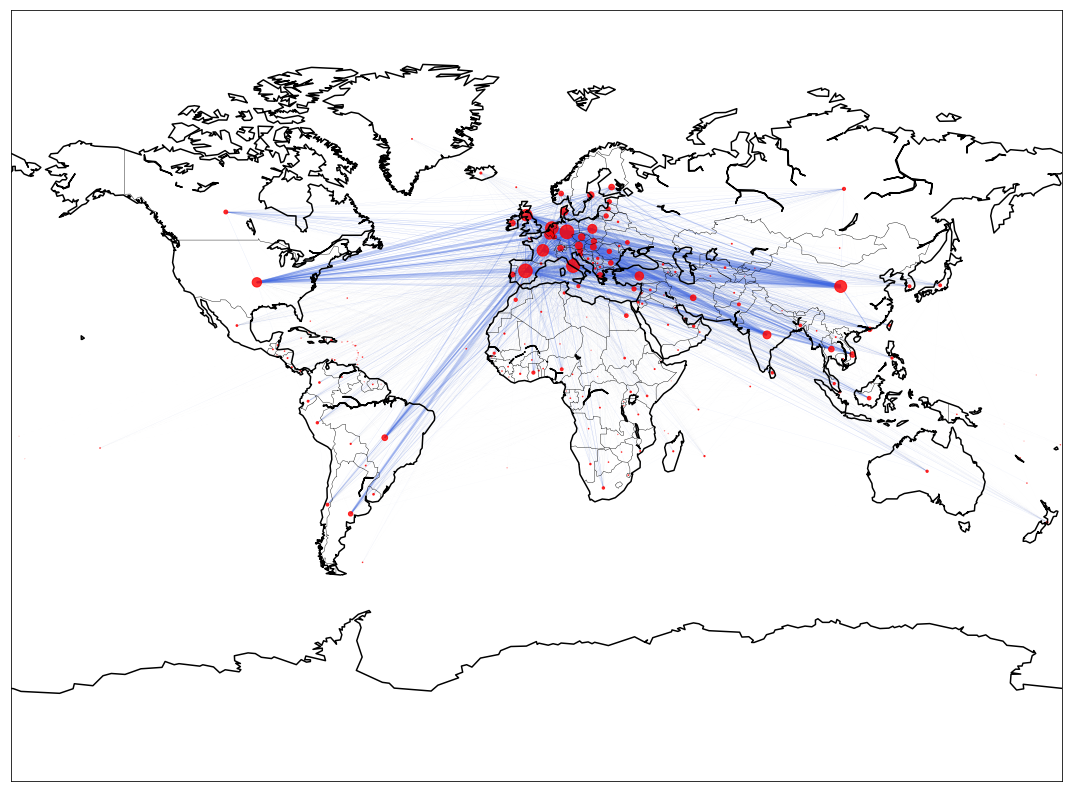

successful visualization


In [404]:
graph = nx.from_pandas_edgelist(full_routes, source = 'Origen', target = 'Destino',
                        edge_attr = 'Number',create_using = nx.DiGraph())
plt.figure(figsize=(15,20))
m = Basemap(projection='mill')
edges = graph.edges()
weights = [graph[u][v]['Number'] for u,v in edges] 
weights[:] = [x / 300 for x in weights]
mx, my = m(node_data['LONGITUDE'].values, node_data['LATITUDE'].values)
pos = {}
for count, elem in enumerate (node_data['COUNTRY']):
    pos[elem] = (mx[count], my[count])
nx.draw_networkx_nodes(G = graph, pos = pos, node_list = graph.nodes(), node_color = 'r', alpha = 0.8,
                       node_size = [node_data.set_index('COUNTRY')['Nodo_size'][s]/100 for s in graph.nodes()])
nx.draw_networkx_edges(G = graph, pos = pos, edge_color='royalblue', width = weights, 
                       alpha=0.3, arrows = False)

m.drawcountries(linewidth = 0.4)
m.drawstates(linewidth =0)
m.drawcoastlines(linewidth=1.5)
plt.tight_layout()
plt.show()
print ("successful visualization")

## Grafo con etiquetas

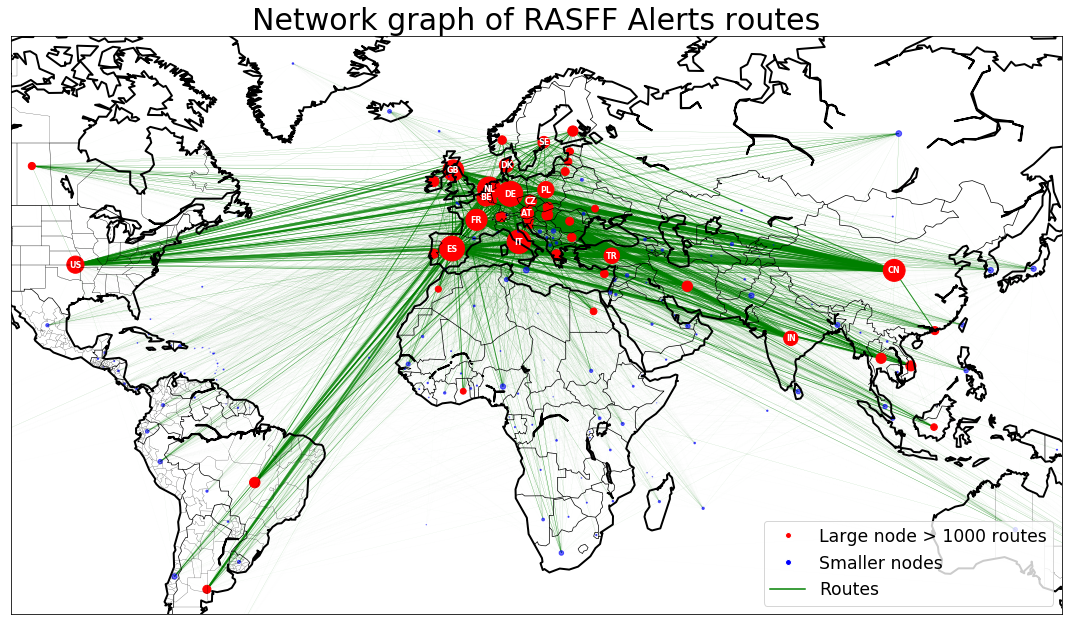

successful visualization


In [403]:
graph = nx.from_pandas_edgelist(full_routes, source = 'Origen', target = 'Destino',
                        edge_attr = 'Number', create_using = nx.DiGraph(directed=True))
                                     
nx.set_node_attributes(graph, por_origen, 'por_origen')
plt.figure(figsize=(15,20))
m = Basemap(projection='mill',llcrnrlon = -111.514246, llcrnrlat =-43.539769 , urcrnrlon = 145.194897, urcrnrlat=75.233846)
mx, my = m(node_data['LONGITUDE'].values, node_data['LATITUDE'].values)
pos = {}
for count, elem in enumerate (node_data['COUNTRY']):
    pos[elem] = (mx[count], my[count])
labels = {}
for x in node_data['CODE'] :
    if  node_data.set_index('CODE')['Nodo_size'][x] >= 4000:
        for y in graph.nodes():
            if  node_data.set_index('COUNTRY')['Nodo_size'][y] >= 4000:
                if node_data.set_index('COUNTRY')['CODE'][y] == x:
                    labels[y] = x
                    
edges = graph.edges()
weights = [graph[u][v]['Number'] for u,v in edges] 
weights[:] = [x / 300 for x in weights]
nx.draw_networkx_nodes(G = graph, pos = pos, nodelist = [x for x in graph.nodes() if node_data.set_index('COUNTRY')['Nodo_size'][x] >= 1000],
                       node_color = 'r',vmin = 0,vmax = 1,cmap=plt.cm.jet, alpha = 1,
                       node_size =  [node_data.set_index('COUNTRY')['Nodo_size'][x]/30  for x in graph.nodes() if node_data.set_index('COUNTRY')['Nodo_size'][x] >= 1000])
nx.draw_networkx_labels(G = graph, pos = pos, font_size=8,
                        labels = labels,font_color='w',font_weight = 'bold')
nx.draw_networkx_nodes(G = graph, pos = pos, nodelist =[x for x in graph.nodes() if node_data.set_index('COUNTRY')['Nodo_size'][x] < 1000],
                       node_color = 'b', alpha = 0.6,
                       node_size =  [node_data.set_index('COUNTRY')['Nodo_size'][x]/30 for x in graph.nodes() if node_data.set_index('COUNTRY')['Nodo_size'][x] < 1000])
nx.draw_networkx_edges(G = graph, pos = pos, edge_color = 'g', width = weights, 
                       alpha=0.8, arrows = False)
m.drawcountries(linewidth = 0.7)
m.drawstates(linewidth = 0.2)
m.drawcoastlines(linewidth=2)
m.fillcontinents(alpha = 0)
line1 = mlines.Line2D(range(1), range(1), color="white", marker='o', markerfacecolor="red")
line2 = mlines.Line2D(range(1), range(1), color="white", marker='o',markerfacecolor="blue")
line3 = mlines.Line2D(range(1), range(1), color="green", marker='',markerfacecolor="green")
plt.legend((line1, line2, line3), ('Large node > 1000 routes', 'Smaller nodes', 'Routes'),
           loc=4, fontsize = 'xx-large')
plt.title("Network graph of RASFF Alerts routes", fontsize = 30)
plt.tight_layout()
plt.show()
print ("successful visualization")

## Grafo con etiquetas y colores

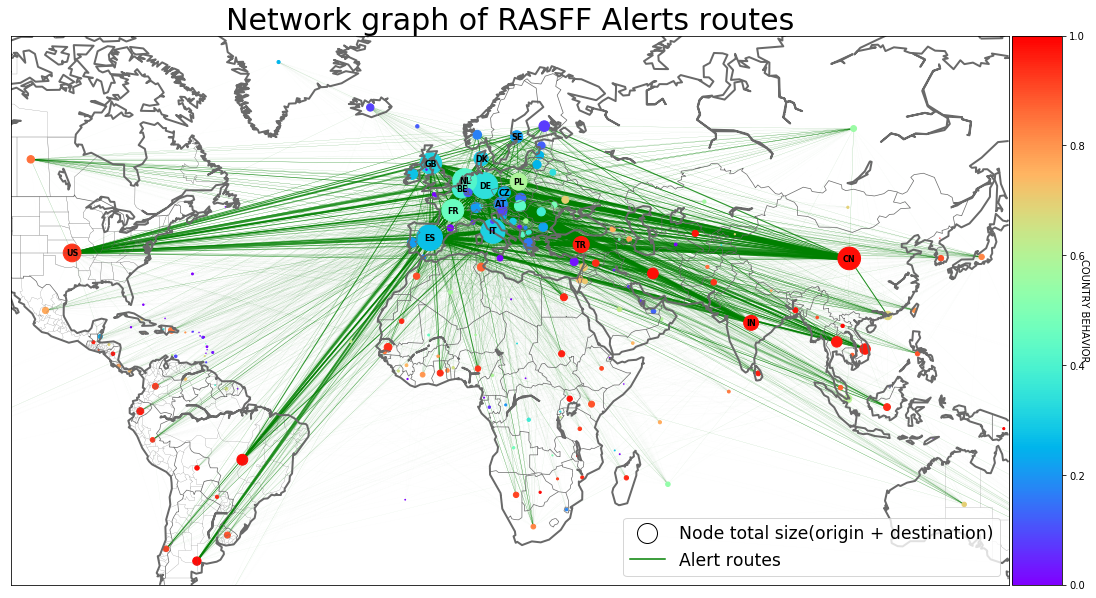

successful visualization


In [402]:
graph = nx.from_pandas_edgelist(full_routes, source = 'Origen', target = 'Destino',
                        edge_attr = 'Number', create_using = nx.DiGraph(directed=True))                                     
nx.set_node_attributes(graph, por_origen, 'por_origen')
plt.figure(figsize=(15,20))
m = Basemap(projection='mill',llcrnrlon = -111.514246, llcrnrlat =-43.539769 , urcrnrlon = 145.194897, urcrnrlat=75.233846)
mx, my = m(node_data['LONGITUDE'].values, node_data['LATITUDE'].values)
pos = {}
for count, elem in enumerate (node_data['COUNTRY']):
    pos[elem] = (mx[count], my[count])
labels = {}
for x in node_data['CODE'] :
    if  node_data.set_index('CODE')['Nodo_size'][x] >= 4000:
        for y in graph.nodes():
            if  node_data.set_index('COUNTRY')['Nodo_size'][y] >= 4000:
                if node_data.set_index('COUNTRY')['CODE'][y] == x:
                    labels[y] = x             
edges = graph.edges()
weights = [graph[u][v]['Number'] for u,v in edges] 
weights[:] = [x / 300 for x in weights]
nc = nx.draw_networkx_nodes(G = graph, pos = pos, nodelist = [x for x in graph.nodes()],
                       node_color = list(nx.get_node_attributes(graph,'por_origen').values()),vmin = 0,vmax = 1,cmap=plt.cm.get_cmap('rainbow'), alpha = 1,
                       node_size =  [node_data.set_index('COUNTRY')['Nodo_size'][x]/28 if node_data.set_index('COUNTRY')['Nodo_size'][x] > 500 else node_data.set_index('COUNTRY')['Nodo_size'][x]/8  for x in graph.nodes()])
nx.draw_networkx_labels(G = graph, pos = pos, font_size=8,
                        labels = labels,font_color='k',font_weight = 'bold')
nx.draw_networkx_edges(G = graph, pos = pos, edge_color = 'g', width = weights, 
                       alpha=0.8, arrows = False)
m.drawcountries(linewidth = 0.7,color = 'dimgray')
m.drawstates(linewidth = 0.2,color = 'dimgray')
m.drawcoastlines(linewidth=2,color = 'dimgray')
m.fillcontinents(alpha = 0)
line1 = mlines.Line2D(range(1), range(1), color="white", marker='o', markerfacecolor="white",markeredgecolor="k", markersize=20)
line2 = mlines.Line2D(range(1), range(1), color="green", marker='',markerfacecolor="green")
plt.legend((line1, line2), ('Node total size(origin + destination)', 'Alert routes'),
           loc=4, fontsize = 'xx-large')
plt.title("Network graph of RASFF Alerts routes", fontsize = 30)
plt.tight_layout()
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(nc,cax)
cbar.set_label('COUNTRY BEHAVIOR', rotation=270)
plt.show()
print ("successful visualization")

## Métricas

In [362]:
node_data_see = node_data[node_data['Nodo_size'] > 1000]
node_data_see.sort_values(by=['porc_origen'], ascending = True)

CODE   LATITUDE   LONGITUDE         COUNTRY  Nodo_size  Origen_size  \
51    CY  35.126413   33.429859          Cyprus     1774.0         46.0   
66    FI  61.924110   25.748151         Finland     3161.0        244.0   
196   SI  46.151241   14.995463        Slovenia     2354.0        211.0   
131   LU  49.815273    6.129583      Luxembourg     1859.0        213.0   
60    EE  58.595272   25.013607         Estonia     1547.0        192.0   
198   SK  48.669026   19.699024        Slovakia     2956.0        417.0   
85    GR  39.074208   21.824312          Greece     3606.0        565.0   
163   NO  60.472024    8.468946          Norway     2181.0        369.0   
12    AT  47.516231   14.550072         Austria     5107.0        943.0   
193   SE  60.128161   18.643501          Sweden     4086.0        864.0   
180   PT  39.399872   -8.224454        Portugal     2513.0        532.0   
40    CH  46.818188    8.227512     Switzerland     2992.0        634.0   
21    BG  42.733883   25.485830        Bulgaria     2111.0        466.0   
132   LV  56.879635   24.603189          Latvia     1624.0        406.0   
130   LT  55.169438   23.881275       Lithuania     1883.0        477.0   
95    HR  45.100000   15.200000         Croatia     1308.0        335.0   
52    CZ  49.817492   15.472962  Czech Republic     4116.0       1055.0   
64    ES  40.463667   -3.749220           Spain    18514.0       5004.0   
99    IE  53.412910   -8.243890         Ireland     3260.0        902.0   
55    DK  56.263920    9.501785         Denmark     5737.0       1676.0   
107   IT  41.871940   12.567380           Italy    16663.0       5091.0   
73    GB  55.378051   -3.435973  United Kingdom    13024.0       4057.0   
53    DE  51.165691   10.451526         Germany    18817.0       6423.0   
185   RO  45.943161   24.966760         Romania     1902.0        732.0   
19    BE  50.503887    4.469936         Belgium     9091.0       3513.0   
162   NL  52.132633    5.291266     Netherlands    15978.0       6563.0   
97    HU  47.162494   19.503304         Hungary     3479.0       1498.0   
71    FR  46.227638    2.213749          France    13431.0       6145.0   
175   PL  51.919438   19.145136          Poland     8007.0       4714.0   
92    HK  22.396428  114.109497       Hong Kong     1978.0       1355.0   
224   UA  48.379433   31.165580         Ukraine     1375.0        961.0   
35    CA  56.130366 -106.346771          Canada     1539.0       1316.0   
134   MA  31.791702   -7.092620         Morocco     1111.0       1002.0   
227   US  37.090240  -95.712891   United States     8830.0       8216.0   
78    GH   7.946527   -1.023194           Ghana     1020.0        961.0   
98    ID  -0.789275  113.921327       Indonesia     1312.0       1237.0   
61    EG  26.820553   30.802498           Egypt     1373.0       1307.0   
235   VN  14.058324  108.277199         Vietnam     3051.0       2936.0   
212   TH  15.870032  100.992541        Thailand     3103.0       2996.0   
219   TR  38.963745   35.243322          Turkey     7270.0       7039.0   
102   IN  20.593684   78.962880           India     6228.0       6106.0   
105   IR  32.427908   53.688046            Iran     3240.0       3178.0   
28    BR -14.235004  -51.925280          Brazil     3284.0       3223.0   
45    CN  35.861660  104.195397           China    14340.0      14102.0   
10    AR -38.416097  -63.616672       Argentina     1960.0       1932.0   

     Destino_size  porc_origen  
51         1728.0     0.025930  
66         2917.0     0.077191  
196        2143.0     0.089635  
131        1646.0     0.114578  
60         1355.0     0.124111  
198        2539.0     0.141069  
85         3041.0     0.156683  
163        1812.0     0.169188  
12         4164.0     0.184649  
193        3222.0     0.211454  
180        1981.0     0.211699  
40         2358.0     0.211898  
21         1645.0     0.220748  
132        1218.0     0.250000  
130        1406.0     0.253319  
95          973.0     0.2

In [377]:
node_data[node_data['COUNTRY'] == 'China']

CODE  LATITUDE   LONGITUDE COUNTRY  Nodo_size  Origen_size  Destino_size  \
45   CN  35.86166  104.195397   China    14340.0      14102.0         238.0   

    porc_origen  
45     0.983403

## Zoom en Europa

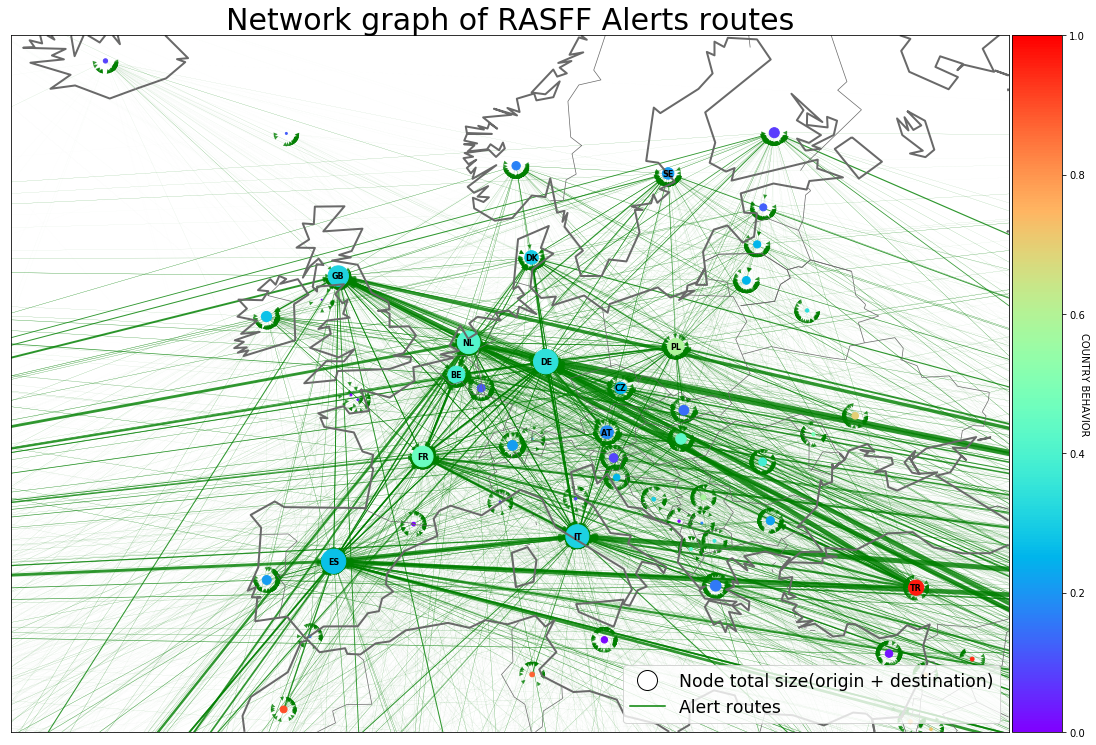

successful visualization


In [417]:
graph = nx.from_pandas_edgelist(full_routes, source = 'Origen', target = 'Destino',
                        edge_attr = 'Number', create_using = nx.DiGraph(directed=True))
                                     
nx.set_node_attributes(graph, por_origen, 'por_origen')
plt.figure(figsize=(15,20))
m = Basemap(projection='mill',llcrnrlon = -25.363250, llcrnrlat =30.431378 , urcrnrlon = 41.433512, urcrnrlat=66.008846)
mx, my = m(node_data['LONGITUDE'].values, node_data['LATITUDE'].values)
pos = {}
for count, elem in enumerate (node_data['COUNTRY']):
    pos[elem] = (mx[count], my[count])  
labels = {}
for x in node_data['CODE'] :
    if  node_data.set_index('CODE')['Nodo_size'][x] >= max(node_data.set_index('CODE')['Nodo_size'])/5:
        for y in graph.nodes():
            if  node_data.set_index('COUNTRY')['Nodo_size'][y] >= max(node_data.set_index('CODE')['Nodo_size'])/5:
                if node_data.set_index('COUNTRY')['CODE'][y] == x:
                    labels[y] = x                 
edges = graph.edges()
weights = [graph[u][v]['Number'] for u,v in edges] 
weights[:] = [x / max(weights)*5 for x in weights]
nc = nx.draw_networkx_nodes(G = graph, pos = pos, nodelist = [x for x in graph.nodes()],
                       node_color = list(nx.get_node_attributes(graph,'por_origen').values()),vmin = 0,vmax = 1,cmap=plt.cm.get_cmap('rainbow'), alpha = 1,
                       node_size =  [node_data.set_index('COUNTRY')['Nodo_size'][x]/max(node_data.set_index('COUNTRY')['Nodo_size'])*600 if node_data.set_index('COUNTRY')['Nodo_size'][x] > max(node_data.set_index('COUNTRY')['Nodo_size'])/15 else node_data.set_index('COUNTRY')['Nodo_size'][x]/max(node_data.set_index('COUNTRY')['Nodo_size'])*800  for x in graph.nodes()])
nx.draw_networkx_labels(G = graph, pos = pos, font_size=8,
                        labels = labels,font_color='k',font_weight = 'bold')
nx.draw_networkx_edges(G = graph, pos = pos, edge_color = 'g',edge_vmin = 0,
                       edge_vmax =1, 
                       edge_cmap=plt.cm.get_cmap('Greens'), width = weights, 
                       alpha=0.8, arrows = True)
m.drawcountries(linewidth = 0.7,color = 'dimgray')
m.drawstates(linewidth = 0.2,color = 'dimgray')
m.drawcoastlines(linewidth=2,color = 'dimgray')
m.fillcontinents(alpha = 0)
line1 = mlines.Line2D(range(1), range(1), color="white", marker='o', markerfacecolor="white",markeredgecolor="k", markersize=20)
line2 = mlines.Line2D(range(1), range(1), color="green", marker='',markerfacecolor="green")
plt.legend((line1, line2), ('Node total size(origin + destination)', 'Alert routes'),
           loc=4, fontsize = 'xx-large')
plt.title("Network graph of RASFF Alerts routes", fontsize = 30)
plt.tight_layout()
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(nc,cax)
cbar.set_label('COUNTRY BEHAVIOR', rotation=270)
plt.savefig("europa_full_map.png", format = "png", dpi = 300,bbox_inches='tight')
plt.show()
print ("successful visualization")